# Recurrent Neural Network - Long Short-Term Memory (RNN - LSTM)

This project aims to detect whether a bidder in an online auction is a human or a robot using a RNN - LSTM. The dataset is based on bidding behavior, including features such as bid timing, device, country, and auction patterns.

The prediction target is the outcome column, where:

0 = Human bidder

1 = Robot bidder (bot)


# Import and Explore the Data

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf


In [ ]:
#Load & Prepare

df = pd.read_csv('cleaned_train.csv')
df['outcome'] = df['outcome'].astype(int)

# Check for missing value
assert df.isnull().sum().sum() == 0, "There are missing values!"


In [ ]:
print(df.head(3))


                               bidder_id  \
0  001068c415025a009fee375a12cff4fcnht8y   
1  0030a2dd87ad2733e0873062e4f83954mkj86   
2  00a0517965f18610417ee784a05f494d4dw6e   

                         payment_account  \
0  a3d2de7675556553a5f08e4c88d2c228iiasc   
1  a3d2de7675556553a5f08e4c88d2c228jem8t   
2  52743ba515e9c1279ac76e19f00c0b001p3pm   

                                 address  outcome     bid_id auction  \
0  a3d2de7675556553a5f08e4c88d2c2282aj35        0  7179832.0   4ifac   
1  f3bc67b04b43c3cebd1db5ed4941874c9br67        0  6805028.0   obbny   
2  7578f951008bd0b64528bf81b8578d5djy0uy        0  2501797.0   l3o6q   

       merchandise    device          time country               ip  \
0          jewelry  phone561  9.706345e+15      bn  139.226.147.115   
1           mobile  phone313  9.704554e+15      ir     21.67.17.162   
2  books and music  phone451  9.632300e+15      bh   103.165.41.136   

               url                       datetime  
0  vasstdc27m7nks3  

# Feature Engineering

Since RNN and LSTM models are designed to learn from temporal sequences, we constructed a time-ordered sequence of features for each bidder to capture the progression of their bidding behavior.



1. time – Timestamp of the bid relative to the dataset start (in milliseconds).
2. hour – Hour of the day the bid was made (0–23).
3. dayofweek – Day of the week the bid was made (0 = Monday, 6 = Sunday).
4. inter_bid_time – Time interval between consecutive bids by the same bidder.
5. bids_per_auction – Cumulative number of bids a bidder has placed in a given auction.
6. total_bids_per_bidder – Total number of bids made by a bidder across all auctions.
7. device_change – Count of different devices used by a bidder.
8. country_change – Count of different countries associated with the bidder's bids.
9. ip_entropy – Entropy measure of the bidder’s IP addresses (higher = more diverse).
10. auction_url_entropy – Entropy of URLs visited during auctions by the bidder.
11. bid_hour_diff – Difference between the current bid hour and the previous bid hour.
12. avg_bid_interval_per_bidder – Average time between consecutive bids for each bidder.
13. num_unique_auctions_per_bidder – Number of different auctions the bidder participated in.
14. entropy_of_devices – Entropy of the devices used by a bidder (diversity of device usage).
15. std_inter_bid_time – Standard deviation of time intervals between the bidder’s bids.
16. proportion_of_auction_bids_by_bidder – Ratio of a bidder’s bids to total bids in an auction.
17. time_since_last_bid – Time elapsed since the bidder’s previous bid.
18. rank_in_auction – Order/rank of the current bid among all bids in the same auction.

In [ ]:
# Feature Engineering for Numerical Feature

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from scipy.stats import entropy

# Convert datetime column to datetime dtype
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort by bidder and datetime
df = df.sort_values(by=['bidder_id', 'datetime']).reset_index(drop=True)

# Inter-bid time (seconds between consecutive bids)
df['inter_bid_time'] = df.groupby('bidder_id')['time'].diff().fillna(0)

# Cumulative bids per auction per bidder
df['bids_per_auction'] = df.groupby(['bidder_id', 'auction']).cumcount() + 1

# Total bids per bidder
df['total_bids_per_bidder'] = df['bidder_id'].map(df['bidder_id'].value_counts())

# Date-time features
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek

# Device change count
df['device_change'] = df.groupby('bidder_id')['device'].transform(lambda x: (x != x.shift()).astype(int)).fillna(0)

#  Country change count
df['country_change'] = df.groupby('bidder_id')['country'].transform(lambda x: (x != x.shift()).astype(int)).fillna(0)

# Entropy features (IP and URL)
df['ip_entropy'] = df['bidder_id'].map(
    df.groupby('bidder_id')['ip'].agg(lambda x: entropy(x.value_counts(normalize=True)))
)

df['auction_url_entropy'] = df['bidder_id'].map(
    df.groupby('bidder_id')['url'].agg(lambda x: entropy(x.value_counts(normalize=True)))
)

# Time difference between bids in hours
df['bid_hour_diff'] = df.groupby('bidder_id')['datetime'].diff().dt.total_seconds().div(3600).fillna(0)

# Average bid interval per bidder
avg_bid_interval_map = df.groupby('bidder_id')['inter_bid_time'].mean()
df['avg_bid_interval_per_bidder'] = df['bidder_id'].map(avg_bid_interval_map)

# Number of unique auctions per bidder
unique_auctions_map = df.groupby('bidder_id')['auction'].nunique()
df['num_unique_auctions_per_bidder'] = df['bidder_id'].map(unique_auctions_map)

# Entropy of devices per bidder
device_entropy_map = df.groupby('bidder_id')['device'].agg(lambda x: entropy(x.value_counts(normalize=True)))
df['entropy_of_devices'] = df['bidder_id'].map(device_entropy_map)

# Standard deviation of inter-bid time
std_inter_bid_map = df.groupby('bidder_id')['inter_bid_time'].std().fillna(0)
df['std_inter_bid_time'] = df['bidder_id'].map(std_inter_bid_map)

#  Proportion of bids by bidder per auction
total_bids_per_auction = df.groupby('auction')['bidder_id'].transform('count')
df['proportion_of_auction_bids_by_bidder'] = df['total_bids_per_bidder'] / total_bids_per_auction

# time_since_last_bid
df['time_since_last_bid'] = (
    df.sort_values(['bidder_id', 'time'])
      .groupby('bidder_id')['time']
      .diff()
      .fillna(0)
)

# Normalized bid rank in auction (progress of bid within auction)
df['rank_in_auction'] = df.groupby('auction')['time'].rank(pct=True)


# Final list of numerical features for scaling
numerical_cols = [
    'time', 'hour', 'dayofweek', 'inter_bid_time', 'bids_per_auction',
    'total_bids_per_bidder', 'device_change', 'country_change', 'ip_entropy',
    'auction_url_entropy','bid_hour_diff','avg_bid_interval_per_bidder', 'num_unique_auctions_per_bidder',
    'entropy_of_devices', 'std_inter_bid_time', 'proportion_of_auction_bids_by_bidder', 'time_since_last_bid', 'rank_in_auction'
]

# Normalize all numerical features
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [ ]:
print(df.head(3))


                               bidder_id  \
0  001068c415025a009fee375a12cff4fcnht8y   
1  0030a2dd87ad2733e0873062e4f83954mkj86   
2  00a0517965f18610417ee784a05f494d4dw6e   

                         payment_account  \
0  a3d2de7675556553a5f08e4c88d2c228iiasc   
1  a3d2de7675556553a5f08e4c88d2c228jem8t   
2  52743ba515e9c1279ac76e19f00c0b001p3pm   

                                 address  outcome     bid_id auction  \
0  a3d2de7675556553a5f08e4c88d2c2282aj35        0  7179832.0   4ifac   
1  f3bc67b04b43c3cebd1db5ed4941874c9br67        0  6805028.0   obbny   
2  7578f951008bd0b64528bf81b8578d5djy0uy        0  2501797.0   l3o6q   

       merchandise    device      time country  ... ip_entropy  \
0          jewelry  phone561  0.993191      bn  ...    0.00000   
1           mobile  phone313  0.993008      ir  ...    0.00000   
2  books and music  phone451  0.985615      bh  ...    0.40193   

  auction_url_entropy bid_hour_diff  avg_bid_interval_per_bidder  \
0            0.000000   

# Feature analysis for Numerical feature
Analyzed distributions and patterns in numerical data to understand feature behavior.


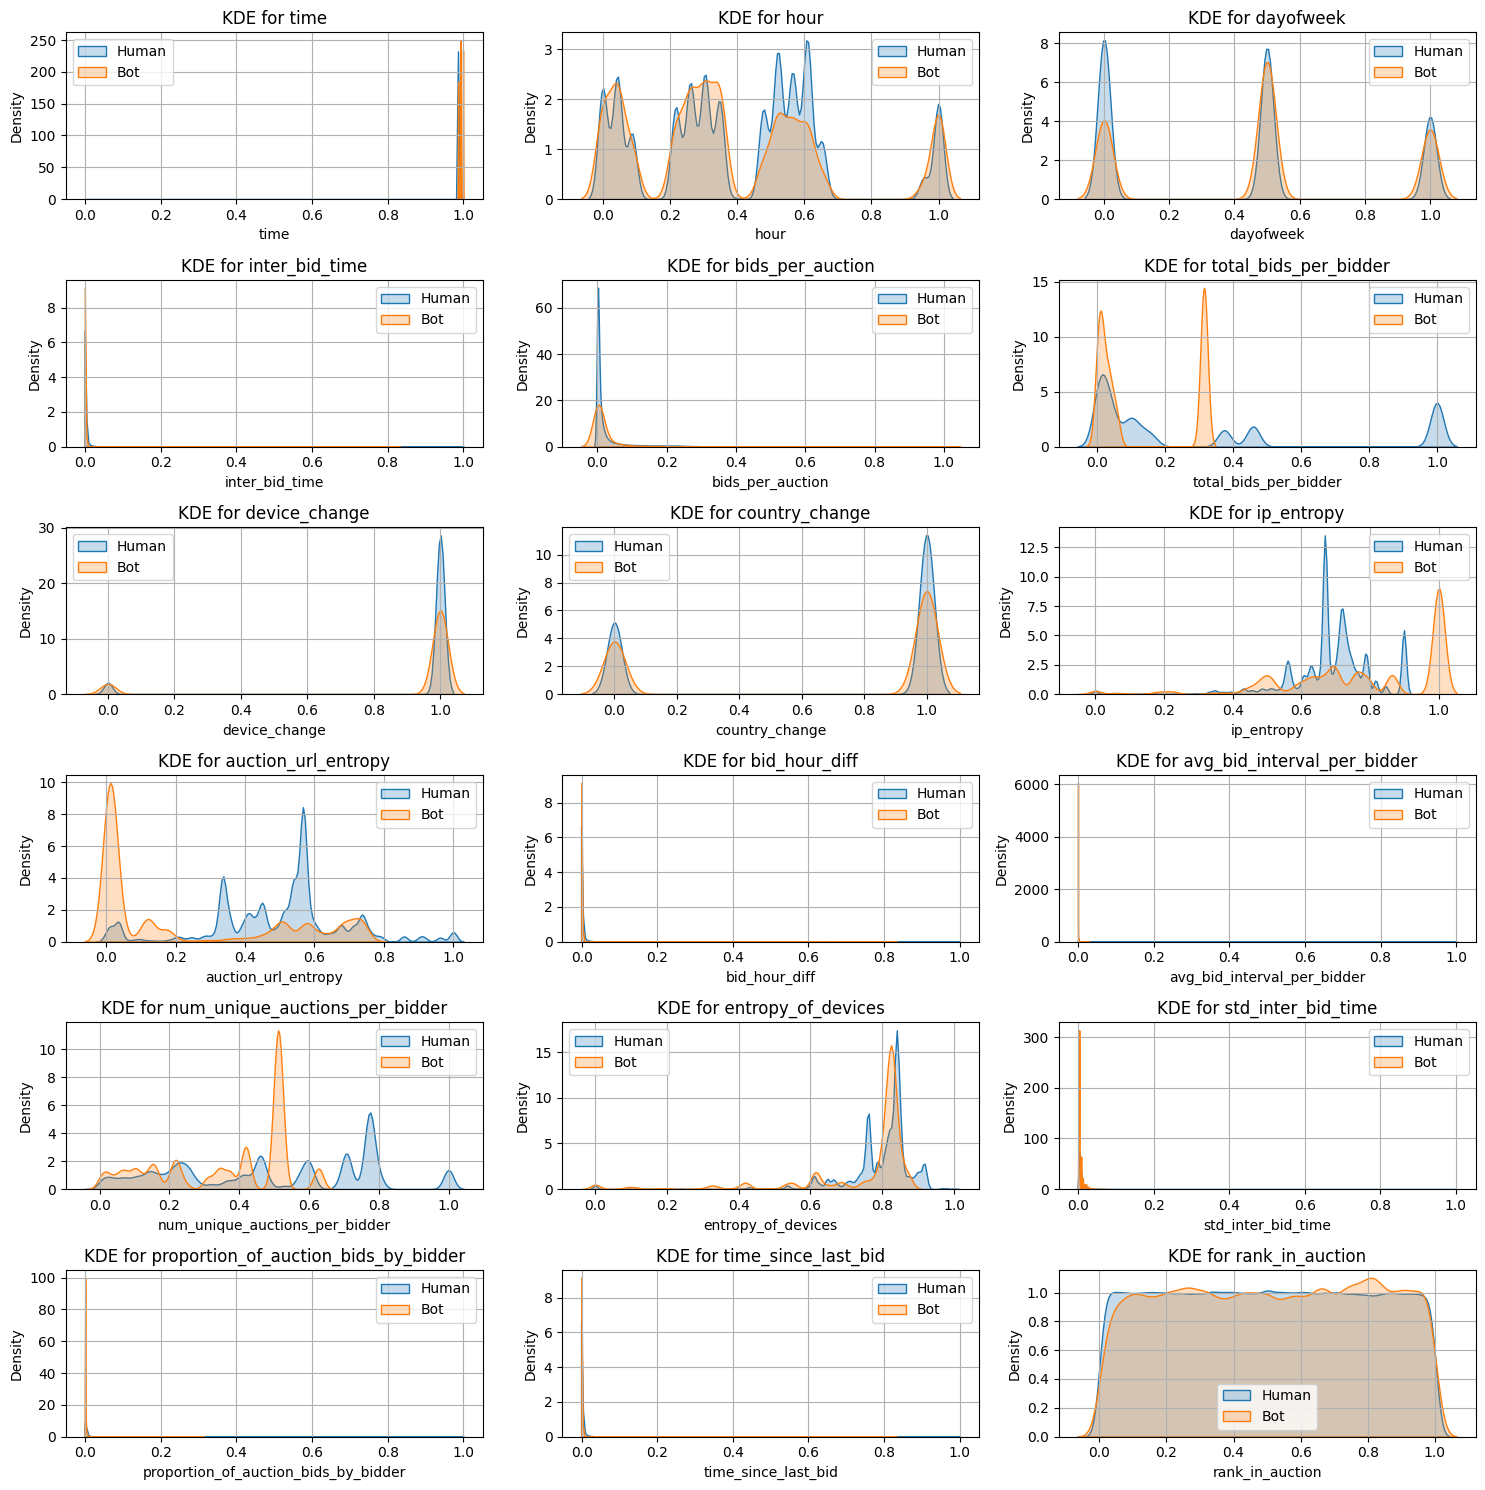

In [ ]:
# Feature importance analysis for numerical feature

import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_kde_features(df, feature_list, label_col='outcome', cols=3, figsize=(15, 15)):
    num_features = len(feature_list)
    rows = math.ceil(num_features / cols)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, feature in enumerate(feature_list):
        sns.kdeplot(data=df[df[label_col] == 0], x=feature, label='Human', fill=True, common_norm=False, ax=axes[i])
        sns.kdeplot(data=df[df[label_col] == 1], x=feature, label='Bot', fill=True, common_norm=False, ax=axes[i])
        axes[i].set_title(f'KDE for {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Density')
        axes[i].legend()
        axes[i].grid(True)

    # Turn off any extra axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


plot_kde_features(df, numerical_cols, label_col='outcome')


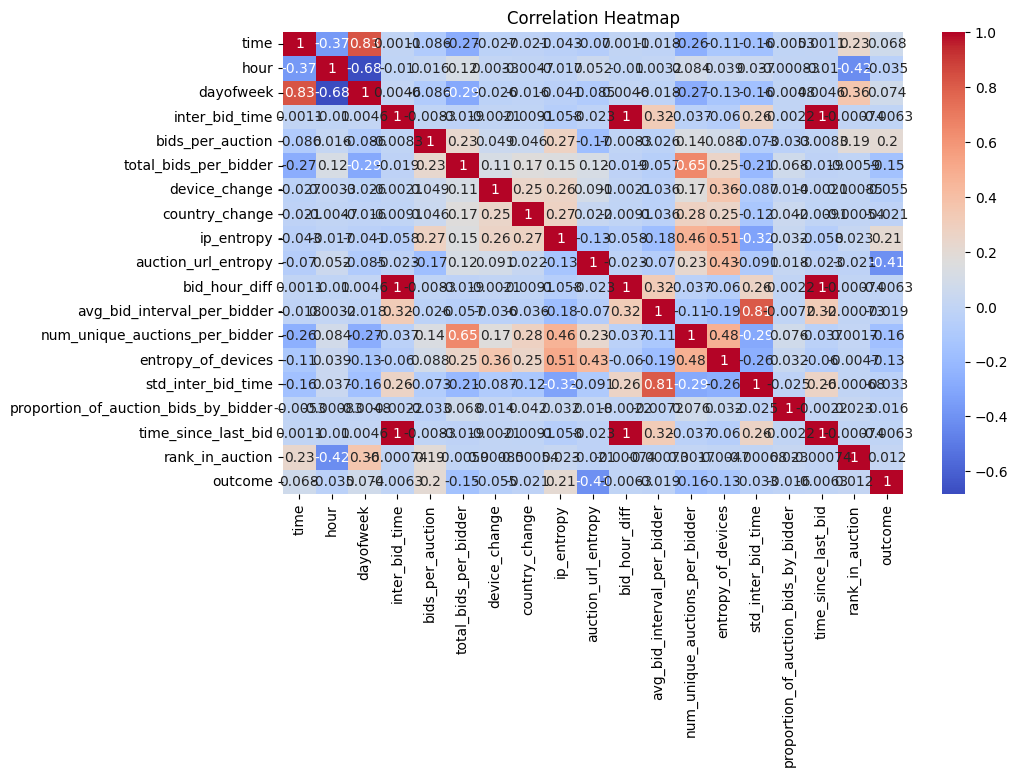

In [ ]:
# Correlation Heatmap for Numerical Feature

plt.figure(figsize=(10, 6))
corr_matrix = df[numerical_cols + ['outcome']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Encoding Categoricla Features
Converted categorical variables into numerical format using encoding techniques.

In [ ]:
# Frequency encode categorical features
categorical_features = ['auction', 'merchandise', 'device', 'country', 'ip','url']

def frequency_encode(df, columns):
    for col in columns:
        freq = df[col].value_counts()
        df[col] = df[col].map(freq)
    return df

df = frequency_encode(df, categorical_features)

# Feature analysis for Categorical feature
Explored category distributions to detect imbalance and assess relevance.

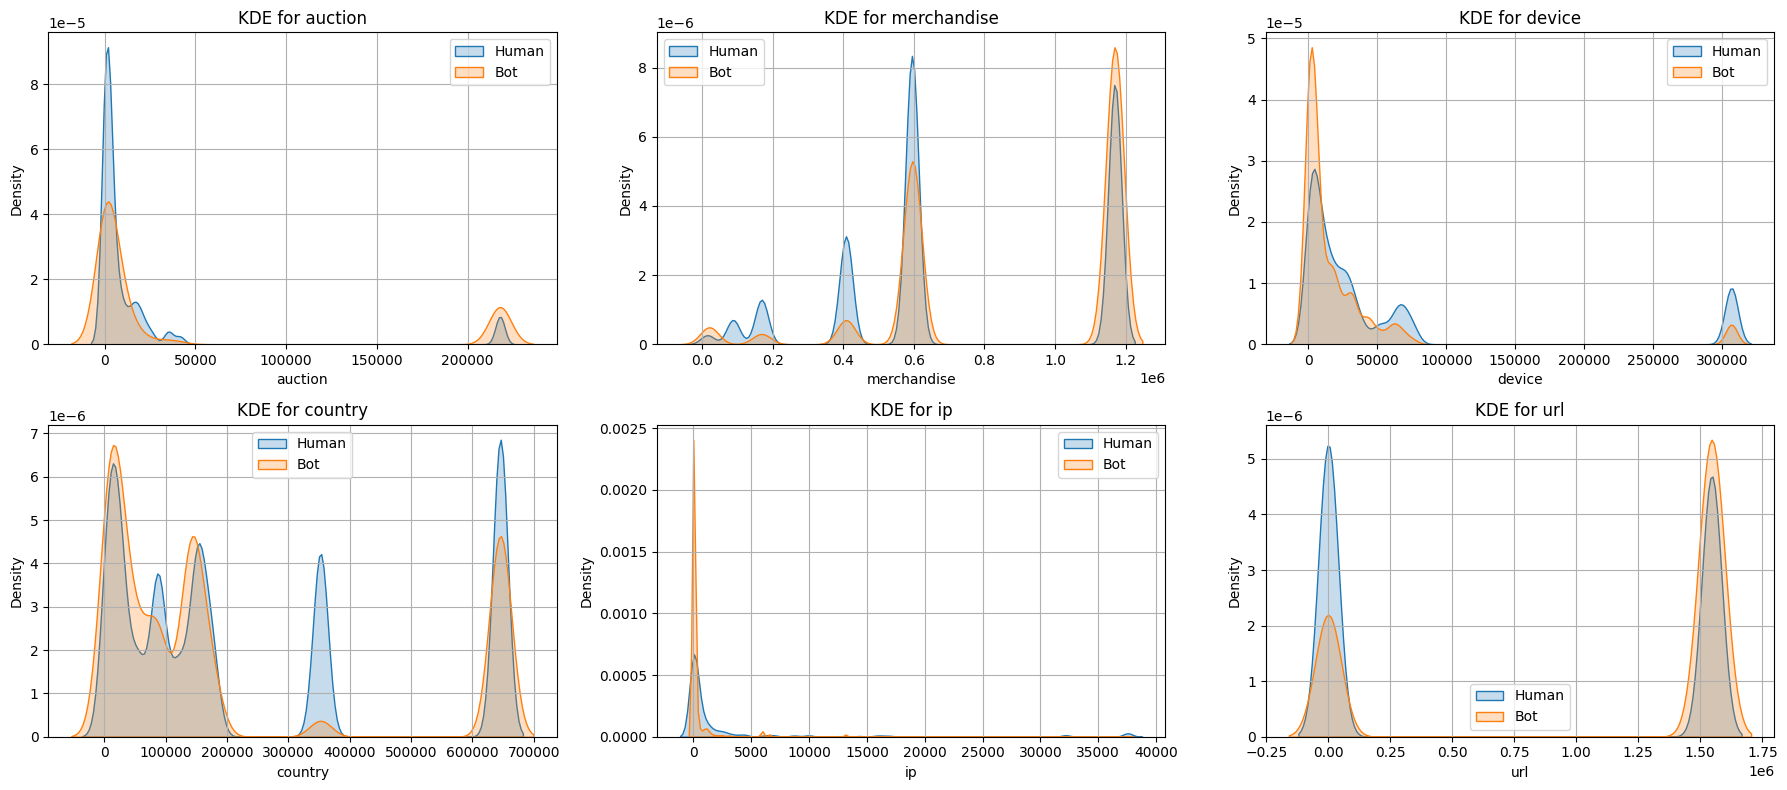

In [ ]:
# Feature analysis for Categorical feature

import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_encoded_distributions(df, feature_list, label_col='outcome', n_cols=3):
    n_features = len(feature_list)
    n_rows = math.ceil(n_features / n_cols)

    plt.figure(figsize=(6 * n_cols, 4 * n_rows))

    for idx, feature in enumerate(feature_list):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.kdeplot(data=df[df[label_col] == 0], x=feature, label='Human', fill=True, common_norm=False)
        sns.kdeplot(data=df[df[label_col] == 1], x=feature, label='Bot', fill=True, common_norm=False)
        plt.title(f'KDE for {feature}')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

categorical_features = ['auction', 'merchandise', 'device', 'country', 'ip', 'url']
plot_encoded_distributions(df, categorical_features, label_col='outcome')


### Observation


In [ ]:
# Decide Useful Feature for model

wanted_features = [
    'merchandise',
    'auction',
    'url',
    'auction_url_entropy',
    'num_unique_auctions_per_bidder',
    'entropy_of_devices',
    'total_bids_per_bidder',
    'proportion_of_auction_bids_by_bidder',
    'ip_entropy',
    'bidder_id',
    'datetime',
    'outcome'
]

df = df[wanted_features]


In [ ]:
print(df.head(3))


   merchandise  auction      url  auction_url_entropy  \
0       592735     1365  1546060             0.000000   
1       597488    12514        1             0.000000   
2        15242       17        2             0.453017   

   num_unique_auctions_per_bidder  entropy_of_devices  total_bids_per_bidder  \
0                        0.000000            0.000000               0.000000   
1                        0.000000            0.000000               0.000000   
2                        0.045006            0.670954               0.000272   

   proportion_of_auction_bids_by_bidder  ip_entropy  \
0                          1.413524e-09     0.00000   
1                          1.462460e-10     0.00000   
2                          1.610404e-05     0.40193   

                               bidder_id                      datetime  \
0  001068c415025a009fee375a12cff4fcnht8y 1970-04-23 08:12:25.052631578   
1  0030a2dd87ad2733e0873062e4f83954mkj86 1970-04-23 07:42:33.947368420   
2  00a0

# Create Sequences
Formed input sequences suitable for time-series or sequential model training.

In [ ]:
# Create sequences

from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

MAX_SEQ_LEN = 30

input_features = [
    'merchandise',
    'auction',
    'url',
    'auction_url_entropy',
    'num_unique_auctions_per_bidder',
    'entropy_of_devices',
    'total_bids_per_bidder',
    'proportion_of_auction_bids_by_bidder',
    'ip_entropy'
]

X_seq = []
y = []

for bidder_id, group in df.groupby('bidder_id'):
    group = group.sort_values(by='datetime')

    # Take the last MAX_SEQ_LEN rows
    values = group[input_features].values
    sequence = values[-MAX_SEQ_LEN:]

    X_seq.append(sequence)
    y.append(group['outcome'].iloc[0])  # Label for the bidder

# Pad sequences to ensure uniform shape
X_pad = pad_sequences(X_seq, maxlen=MAX_SEQ_LEN, padding='post', dtype='float32')
y = np.array(y)


# Train-Test Split
Divided the dataset into training and testing sets for model validation.

In [ ]:
#Train-Test Split

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_pad, y,
    test_size=0.2,        # 20% of data goes to validation
    stratify=y,           # keep class distribution balanced
    random_state=42       # for reproducibility
)

print("Train distribution:", np.bincount(y_train))
print("Validation distribution:", np.bincount(y_val))



Train distribution: [1528   82]
Validation distribution: [382  21]


# Compute Class Weight
Calculated weights to handle class imbalance during training.

In [ ]:
# Compute Class Weight
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Print label distribution
unique, counts = np.unique(y_train, return_counts=True)
label_distribution = dict(zip(unique, counts))
print("Label distribution in y_train:", label_distribution)

# Compute class weights automatically
computed_class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
print("Auto Class Weights:", dict(enumerate(computed_class_weights)))

# Optionally smooth the weights
class_weights_dict = {
    0: 1.0,   # Human
    1: 10.0    # Bot
}
print("Used Class Weights:", class_weights_dict)

# Setup EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
    restore_best_weights=True
)


Label distribution in y_train: {np.int64(0): np.int64(1528), np.int64(1): np.int64(82)}
Auto Class Weights: {0: np.float64(0.5268324607329843), 1: np.float64(9.817073170731707)}
Used Class Weights: {0: 1.0, 1: 10.0}


# Model Training With Evaluation
Trained the model and evaluated performance using AUC score and loss metrics.

In [ ]:
# Model Building

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.metrics import AUC

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(30, 9)))
model.add(LSTM(64, return_sequences=True))  # Removed Bidirectional wrapper
model.add(LSTM(32, return_sequences=False))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC()])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Train the model with class weights

history= model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      epochs=30,
      batch_size=64,
      callbacks=[early_stop],
      class_weight=class_weights_dict,
      verbose=1
)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5009 - auc_1: 0.4794 - loss: 1.5696 - val_accuracy: 0.8387 - val_auc_1: 0.6018 - val_loss: 0.8510
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5507 - auc_1: 0.4750 - loss: 1.3578 - val_accuracy: 0.9380 - val_auc_1: 0.6665 - val_loss: 0.7935
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5999 - auc_1: 0.6123 - loss: 1.2208 - val_accuracy: 0.8834 - val_auc_1: 0.7813 - val_loss: 0.7914
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6533 - auc_1: 0.7402 - loss: 1.1108 - val_accuracy: 0.8734 - val_auc_1: 0.7884 - val_loss: 0.7655
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6829 - auc_1: 0.8018 - loss: 0.9978 - val_accuracy: 0.9231 - val_auc_1: 0.7883 - val_loss: 0.7295
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6810 - auc_1: 0.7983 - loss: 0.9733 - val_accuracy: 0.9479 - val_auc_1: 0.8080 - val_loss: 0.6264
Epoch 7/30
26/26 ━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
📊 Classification Report:
              precision    recall  f1-score   support

       Human       0.98      0.88      0.92       382
         Bot       0.22      0.62      0.32        21

    accuracy                           0.86       403
   macro avg       0.60      0.75      0.62       403
weighted avg       0.94      0.86      0.89       403

🔍 Confusion Matrix:
[[335  47]
 [  8  13]]
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9514 - auc_1: 0.8237 - loss: 0.3099
AUC Score: 0.8528


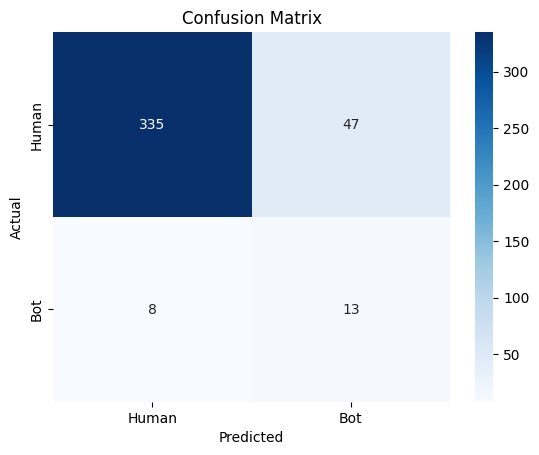

In [ ]:
# Evaluate
from sklearn.metrics import classification_report, confusion_matrix

# Predict on validation set
y_pred = (model.predict(X_val) > 0.25).astype("int32") ###############

# Print detailed classification metrics
print("📊 Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Human", "Bot"]))

# Show confusion matrix
print("🔍 Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


loss, acc, auc_score = model.evaluate(X_val, y_val)
print(f"AUC Score: {auc_score:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Human", "Bot"], yticklabels=["Human", "Bot"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



# ROC Curve and Loss Plot
ROC Curve and Loss Plot help to
visualize model performance and learning behavior through ROC and loss plots.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


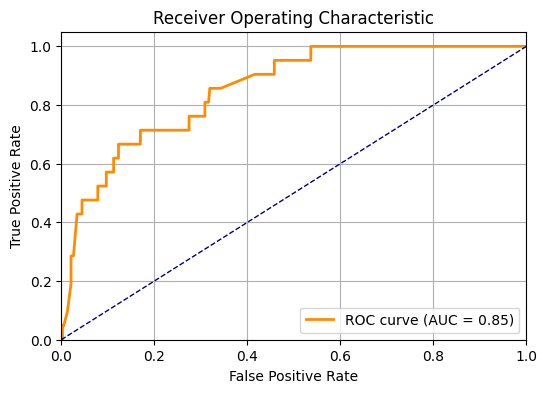

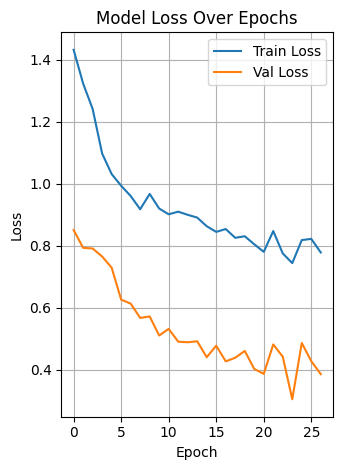

In [ ]:
import matplotlib.pyplot as plt

# ROC Curve
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for validation set
y_val_pred_prob = model.predict(X_val).ravel()  # Flatten to 1D if needed

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



### Save the model for evaluation and comparision purpose.

In [ ]:
import joblib
joblib.dump(model, 'rnn_best_model.pkl')